## Reproductible forecasting

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import jmstate
from jmstate import MultiStateJointModel
from uniformbands import get_bands

In [2]:
torch.manual_seed(0)
sigmoid = torch.jit.script(jmstate.functions.sigmoid)

@torch.jit.script
def f(gamma, x, b):
    psi = gamma + b
    psi[:, 1].exp_()
    return psi

In [3]:
lmda, k = 6, 2
gamma = torch.tensor([4.0, 0.5, 6.0])
Q = torch.diag(torch.tensor([1.0, 0.1, 1.0]))
Q_dist = torch.distributions.MultivariateNormal(torch.zeros(3), Q)
R = torch.tensor([[1.1]])
R_dist = torch.distributions.MultivariateNormal(torch.zeros(1), R)

alphas = {(0, 1): torch.tensor([.7])}
betas = {(0, 1): torch.tensor([-.5, .5, 1.2])}

real_params = jmstate.types.ModelParams(
    gamma,
    (jmstate.utils.flat_from_cov(Q, method="diag"), "diag"),
    (jmstate.utils.flat_from_cov(R, method="ball"), "ball"),
    alphas,
    betas
)

In [4]:
weibull_fn = jmstate.functions.weibull(k, lmda)
surv = {(0, 1): (weibull_fn, sigmoid)}
model_design = jmstate.types.ModelDesign(f, sigmoid, surv)
real_model = MultiStateJointModel(model_design, real_params, n_quad=128)

n, p = 500, 3
t = torch.linspace(0, 15, 15)
c = torch.rand(n) * 5 + 10
x = torch.randn(n, p)

b = Q_dist.sample((n,))
psi = f(gamma, x, b)

trajectories_init = [[(0.0, 0)] for _ in range(n)]
sample_data = jmstate.types.SampleData(x, trajectories_init, psi)
trajectories = real_model.sample_trajectories(sample_data, c)


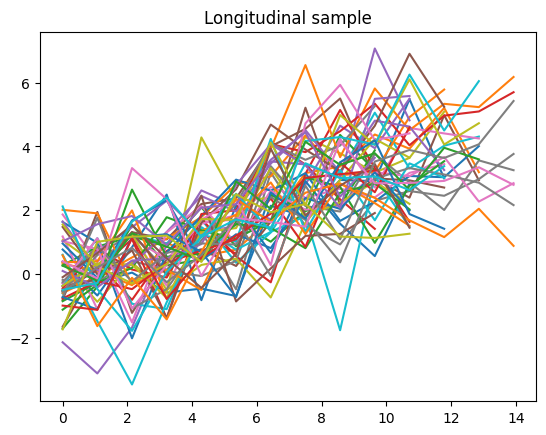

In [5]:
y = model_design.regression_fn(t, psi)
y += R_dist.sample(y.shape[:2])
y[t.repeat(n, 1) > c.view(-1, 1)] = torch.nan

plt.plot(t, y[:50].squeeze(-1).T)
plt.title("Longitudinal sample")
plt.show()

In [6]:
init_params = jmstate.types.ModelParams(
    torch.zeros_like(gamma),
    (torch.zeros_like(jmstate.utils.flat_from_cov(Q, method="diag")), "diag"),
    (torch.zeros_like(jmstate.utils.flat_from_cov(R, method="ball")), "ball"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

data = jmstate.types.ModelData(x, t, y, trajectories, c)
model = MultiStateJointModel(model_design, init_params)
model.fit(data, n_iter=3000)
model.get_metrics(
    callbacks=[jmstate.callbacks.compute_criteria, jmstate.callbacks.compute_fim]
)
std_error = model.get_stderror()
print("Fitted parameters:", model.params_)
print("Fitted metrics:", model.metrics_)
print("Standard Error:", std_error)

Running metrics loop: 100%|██████████| 1000/1000 [00:09<00:00, 104.09it/s]

Fitted parameters: ModelParams(gamma=tensor([4.0418, 0.3986, 5.8559]), Q_repr=(tensor([ 0.0347,  0.7156, -0.0517]), 'diag'), R_repr=(tensor([-0.0504]), 'ball'), alphas={(0, 1): tensor([0.7081])}, betas={(0, 1): tensor([-0.5252,  0.5040,  1.2005])})
Fitted metrics: {'loglik': tensor([-11102.8516]), 'nloglik_pen': tensor([11102.8516]), 'aic': tensor([22227.7031]), 'bic': tensor([22274.0645]), 'fim': tensor([[ 6.3773e+02, -2.8387e+02, -2.2811e+02, -2.3983e+01, -3.6979e+00,
         -5.1946e+00, -1.4065e+00,  6.4874e+01,  8.8509e+00,  2.0920e+01,
         -2.3935e+01],
        [-2.8387e+02,  5.0999e+02,  1.7066e+01,  1.0271e+01,  1.7118e+01,
          2.5569e+00,  4.8635e+01, -1.7271e+01, -1.5230e+01, -2.6836e+00,
          1.7634e+01],
        [-2.2811e+02,  1.7066e+01,  2.3025e+02, -4.0915e+00,  1.2066e+01,
          5.4078e+00, -3.1343e+00, -5.9590e+01, -4.9730e+00, -3.6850e+00,
          7.8873e+00],
        [-2.3983e+01,  1.0271e+01, -4.0915e+00,  1.9914e+02,  5.5161e+00,
          3.

In [7]:
new_params = jmstate.utils.sample_params_from_model(model, 10)
print(new_params)

[ModelParams(gamma=tensor([4.0246, 0.4468, 5.8791]), Q_repr=(tensor([-0.0713,  0.6488, -0.0773]), 'diag'), R_repr=(tensor([-0.0284]), 'ball'), alphas={(0, 1): tensor([0.7441])}, betas={(0, 1): tensor([-0.7390,  0.5308,  1.1577])}), ModelParams(gamma=tensor([4.1392, 0.4639, 5.9943]), Q_repr=(tensor([0.1317, 0.6906, 0.0404]), 'diag'), R_repr=(tensor([-0.0632]), 'ball'), alphas={(0, 1): tensor([0.7345])}, betas={(0, 1): tensor([-0.3933,  0.5578,  1.2125])}), ModelParams(gamma=tensor([3.9329, 0.2924, 5.6151]), Q_repr=(tensor([ 0.1335,  0.7072, -0.0243]), 'diag'), R_repr=(tensor([-0.0494]), 'ball'), alphas={(0, 1): tensor([0.6525])}, betas={(0, 1): tensor([-0.4716,  0.6194,  1.1017])}), ModelParams(gamma=tensor([4.0125, 0.4340, 5.8211]), Q_repr=(tensor([ 0.1776,  0.6811, -0.0703]), 'diag'), R_repr=(tensor([-0.0290]), 'ball'), alphas={(0, 1): tensor([0.7519])}, betas={(0, 1): tensor([-0.5052,  0.5053,  1.2156])}), ModelParams(gamma=tensor([3.9991, 0.3046, 5.8070]), Q_repr=(tensor([ 0.0406,  

In [8]:
n_test = 100
x_test = torch.randn(n_test, p)
b_test = Q_dist.sample((n_test,))
psi_test = f(gamma, x_test, b_test)
trajectories_init_test = [[(0.0, 0)] for _ in range(n_test)]

y_test = model_design.regression_fn(t, psi_test)
y_test += R_dist.sample(y_test.shape[:2])

Predicting survival log probabilities: 100%|██████████| 500/500 [00:15<00:00, 31.29it/s]


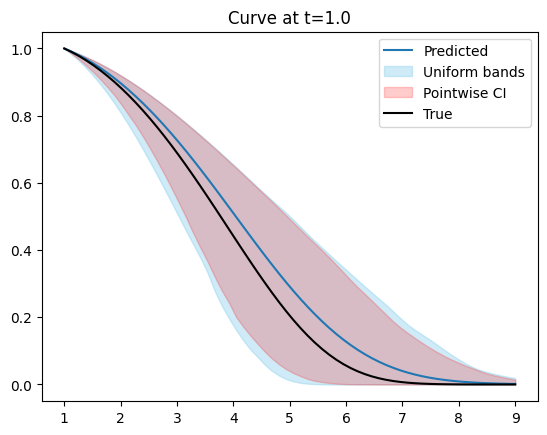

Time 1.0: Uniform coverage = 0.950, Pointwise coverage = 0.850


Predicting survival log probabilities: 100%|██████████| 500/500 [00:18<00:00, 26.64it/s]


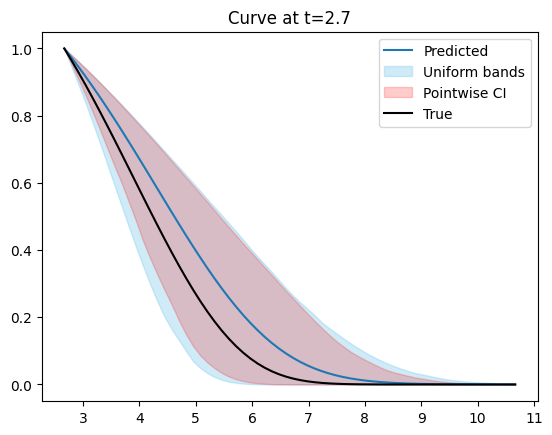

Time 2.7: Uniform coverage = 0.950, Pointwise coverage = 0.910


Predicting survival log probabilities: 100%|██████████| 500/500 [00:15<00:00, 32.84it/s]


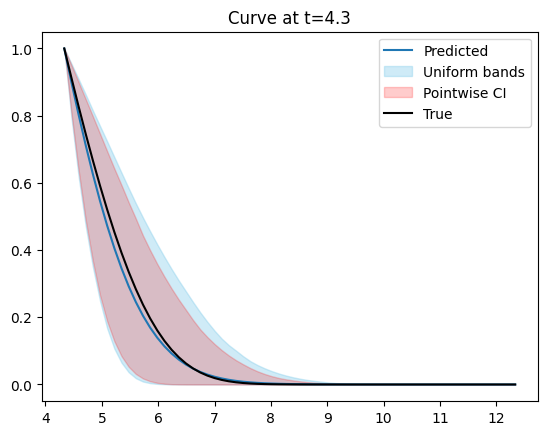

Time 4.3: Uniform coverage = 0.900, Pointwise coverage = 0.840


Predicting survival log probabilities: 100%|██████████| 500/500 [00:19<00:00, 25.49it/s]


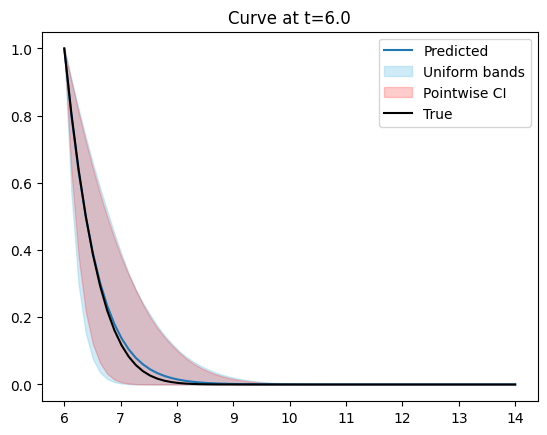

Time 6.0: Uniform coverage = 0.800, Pointwise coverage = 0.750

Overall coverage:
Uniform bands: 0.900
Pointwise CI: 0.838


In [9]:
prediction_times = torch.linspace(1.0, 6.0, 4)
u_grid = torch.linspace(0, 8, 64)

logps_true = []
for time in prediction_times:
    c_test = torch.full((n_test,), time)
    sample_test_data = jmstate.types.SampleData(x_test, trajectories_init_test, psi_test, c_test)
    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    logps_true.append(real_model.compute_surv_logps(sample_test_data, u))

uniform_coverage = []
pointwise_coverage = []

for i, time in enumerate(prediction_times):
    c_test = torch.full((n_test,), time)

    pred_test_data = jmstate.types.ModelData(
        x_test, t[t <= time], y_test[:, t <= time, :],
        trajectories_init_test, c_test
    )

    u = c_test.view(-1, 1) + u_grid.view(1, -1)
    logps_pred = real_model.predict_surv_logps(pred_test_data, u)

    uniform_covered_count = 0
    pointwise_covered_count = 0

    for j in range(n_test):
        true_prob_j = torch.exp(logps_true[i][j]).numpy()
        pred_probs_j = torch.vstack([torch.exp(lp[j].detach()) for lp in logps_pred]).numpy()

        bands_j = get_bands(pred_probs_j)
        pointwise_j = np.quantile(pred_probs_j, [0.025, 0.975], axis=0)

        uniform_covered_count += np.all((true_prob_j >= bands_j["lower"]) & (true_prob_j <= bands_j["upper"]))
        pointwise_covered_count += np.all((true_prob_j >= pointwise_j[0]) & (true_prob_j <= pointwise_j[1]))

        # Plot first curve only
        if j == 0:
            points = time + u_grid
            plt.plot(points, pred_probs_j.mean(axis=0), label="Predicted")
            plt.fill_between(points, bands_j["lower"], bands_j["upper"], color="skyblue", alpha=0.4, label="Uniform bands")
            plt.fill_between(points, pointwise_j[0], pointwise_j[1], color="red", alpha=0.2, label="Pointwise CI")
            plt.plot(points, true_prob_j, label="True", color="black")
            plt.title(f"Curve at t={time:.1f}")
            plt.legend()
            plt.show()

    uniform_coverage.append(uniform_covered_count / n_test)
    pointwise_coverage.append(pointwise_covered_count / n_test)

    print(f"Time {time:.1f}: Uniform coverage = {uniform_coverage[-1]:.3f}, Pointwise coverage = {pointwise_coverage[-1]:.3f}")

print("\nOverall coverage:")
print(f"Uniform bands: {np.mean(uniform_coverage):.3f}")
print(f"Pointwise CI: {np.mean(pointwise_coverage):.3f}")

Predicting longitudinal expected values: 100%|██████████| 500/500 [00:02<00:00, 192.18it/s]


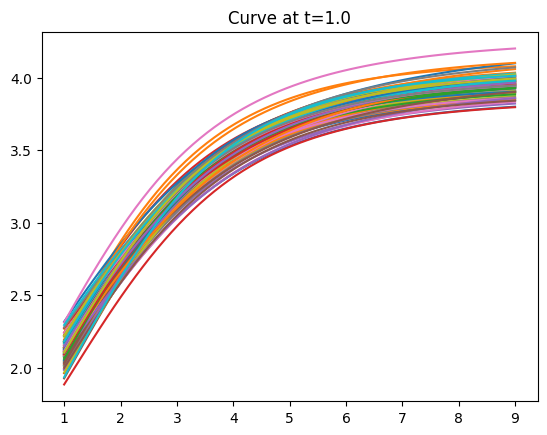

Predicting longitudinal expected values: 100%|██████████| 500/500 [00:02<00:00, 237.98it/s]


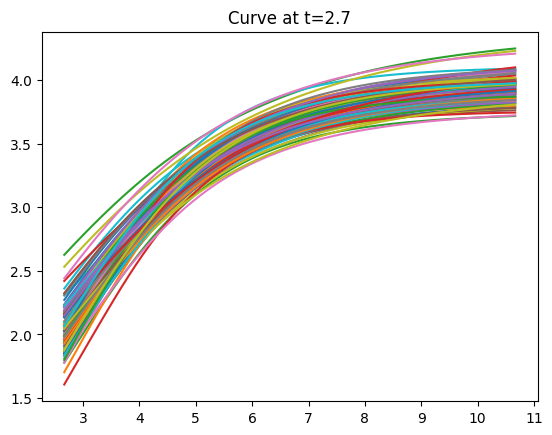

Predicting longitudinal expected values: 100%|██████████| 500/500 [00:02<00:00, 232.20it/s]


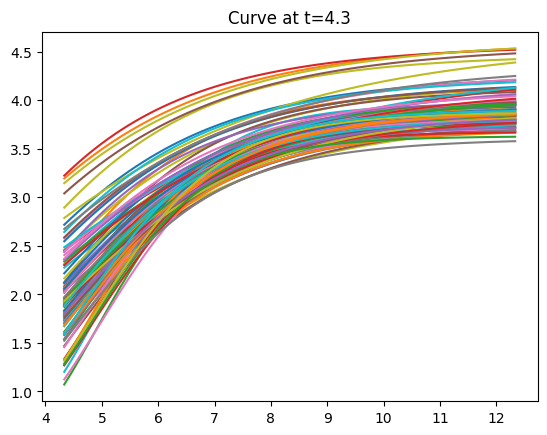

Predicting longitudinal expected values: 100%|██████████| 500/500 [00:02<00:00, 240.29it/s]


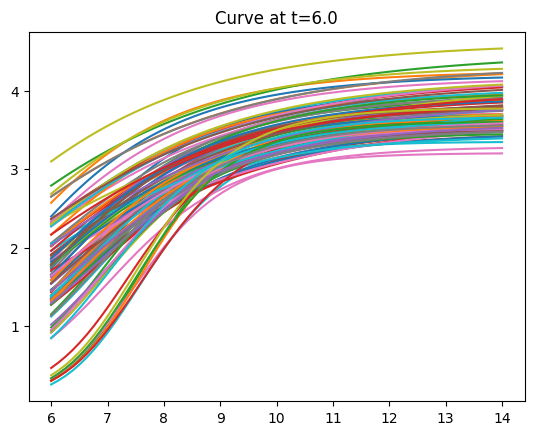

In [10]:
for i, time in enumerate(prediction_times):
    c_test = torch.full((n_test,), time)

    pred_test_data = jmstate.types.ModelData(
        x_test, t[t <= time], y_test[:, t <= time, :],
        trajectories_init_test, c_test
    )
    y_pr = torch.cat(model.predict_y(pred_test_data, u), dim=2)
    points = time + u_grid
    plt.plot(points, y_pr.mean(dim=2).T)
    plt.title(f"Curve at t={time:.1f}")
    plt.show()